In [ ]:
import time
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torchvision
import torchvision.transforms as transforms
from transformers import AutoImageProcessor, AutoModelForImageClassification
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score,precision_score,recall_score
import seaborn as sns
import numpy as np

In [ ]:
# Set a seed for reproducibility to ensure the train/validation split is the same as for ResNet-18
torch.manual_seed(42)

# --- 0. Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model details
model_name = "facebook/deit-tiny-patch16-224"
epochs = 10

Using device: cuda


**1. Data Preprocessing**

In [ ]:
processor = AutoImageProcessor.from_pretrained(model_name)
image_mean = processor.image_mean
image_std = processor.image_std
image_size = processor.size["height"]

print(f"Model expects images of size {image_size}x{image_size}")
print(f"Using model's normalization mean: {image_mean} and std: {image_std}")



transform_train = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(image_mean, image_std)
])


transform_test = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(image_mean, image_std) # Use the model's specific normalization
])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Model expects images of size 224x224
Using model's normalization mean: [0.5, 0.5, 0.5] and std: [0.5, 0.5, 0.5]


**2. Load CIFAR-10**

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)


train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_subset, val_subset = torch.utils.data.random_split(trainset, [train_size, val_size])

print(f"Training set size: {len(train_subset)}")
print(f"Validation set size: {len(val_subset)}")
print(f"Test set size: {len(testset)}")

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:06<00:00, 27.1MB/s]


Training set size: 40000
Validation set size: 10000
Test set size: 10000


**3. Load DeiT-Tiny Model**

In [ ]:
model = AutoModelForImageClassification.from_pretrained(
    model_name,
    num_labels=10, # CIFAR-10 has 10 classes
    ignore_mismatched_sizes=True
)

model = model.to(device)

pytorch_model.bin:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([10, 192]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

**4. Define Loss and Optimizer**

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)


# learning rate scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

**5. Train Model**

In [ ]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

start_time = time.time()

for epoch in range(epochs):
    model.train()
    running_loss, running_corrects = 0.0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_subset)
    epoch_acc = running_corrects.double() / len(train_subset)
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc.cpu().item())

    # Validation loop
    model.eval()
    val_running_loss, val_running_corrects = 0.0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_running_corrects += torch.sum(preds == labels.data)

    val_loss = val_running_loss / len(val_subset)
    val_acc = val_running_corrects.double() / len(val_subset)
    val_losses.append(val_loss)
    val_accs.append(val_acc.cpu().item())

    print(f"Epoch [{epoch+1}/{epochs}] | "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    scheduler.step()

training_time = time.time() - start_time
print(f"\nTotal Training Time: {training_time:.2f} seconds")

Epoch [1/10] | Train Loss: 0.1421, Train Acc: 0.9528 | Val Loss: 0.2812, Val Acc: 0.9124
Epoch [2/10] | Train Loss: 0.1431, Train Acc: 0.9507 | Val Loss: 0.2708, Val Acc: 0.9130
Epoch [3/10] | Train Loss: 0.1320, Train Acc: 0.9552 | Val Loss: 0.2601, Val Acc: 0.9157
Epoch [4/10] | Train Loss: 0.1103, Train Acc: 0.9628 | Val Loss: 0.2339, Val Acc: 0.9259
Epoch [5/10] | Train Loss: 0.0998, Train Acc: 0.9669 | Val Loss: 0.2072, Val Acc: 0.9350
Epoch [6/10] | Train Loss: 0.0828, Train Acc: 0.9721 | Val Loss: 0.2082, Val Acc: 0.9340
Epoch [7/10] | Train Loss: 0.0638, Train Acc: 0.9780 | Val Loss: 0.1944, Val Acc: 0.9398
Epoch [8/10] | Train Loss: 0.0615, Train Acc: 0.9790 | Val Loss: 0.1811, Val Acc: 0.9463
Epoch [9/10] | Train Loss: 0.0530, Train Acc: 0.9816 | Val Loss: 0.1728, Val Acc: 0.9488
Epoch [10/10] | Train Loss: 0.0478, Train Acc: 0.9837 | Val Loss: 0.1734, Val Acc: 0.9500

Total Training Time: 1870.27 seconds


**6. Save Model**



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

output_dir = "/content/drive/My Drive/Colab Notebooks/ViT_Tiny_Final"
os.makedirs(output_dir, exist_ok=True)
path_model = os.path.join(output_dir, "ViT_tiny_trained.pth")
path_epoch_hist = os.path.join(output_dir, "epoch_hist.csv")

Mounted at /content/drive


In [ ]:
torch.save(model.state_dict(), path_model)

epoch_hist = pd.DataFrame({
    "Epoch": range(1, epochs + 1),
    "Train Loss": train_losses, "Train Acc": train_accs,
    "Val Loss": val_losses, "Val Acc": val_accs
})
epoch_hist.to_csv(path_epoch_hist, index=False)
print(f"Model and training history saved to '{output_dir}'")

Model and training history saved to '/content/drive/My Drive/Colab Notebooks/ViT_Tiny_Final'


**7. Test Model**

In [ ]:
model.load_state_dict(torch.load(path_model))
model.eval()

correct, total = 0, 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = correct / total
f1 = f1_score(all_labels, all_preds, average='macro')
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
print(f'\nTest Accuracy: {100 * test_acc:.2f}%')
print(f'Test F1-Score (Macro): {f1:.4f}')
print(f'Test Precision (Macro): {precision:.4f}')
print(f'Test Recall (Macro): {recall:.4f}')


Test Accuracy: 96.92%
Test F1-Score (Macro): 0.9692
Test Precision (Macro): 0.9693
Test Recall (Macro): 0.9692


**8. Inference Time & Model Size**

In [ ]:
# Predict on one image
sample_img, _ = testset[0]
sample_img = sample_img.unsqueeze(0).to(device)

# Warm-up run
with torch.no_grad():
    _ = model(sample_img)

# Measure inference time
start_infer = time.time()
with torch.no_grad():
    output = model(sample_img)
infer_time = time.time() - start_infer
pred = torch.max(output.logits, 1)
print(f"Predicted label for one image: {classes[pred[1].item()]}")
print(f"Inference Time for one image: {infer_time * 1000:.4f} ms")

# Get model size
model_size = os.path.getsize(path_model) / 1e6 # in MB
print(f"Model Size (on disk): {model_size:.2f} MB")

Predicted label for one image: cat
Inference Time for one image: 6.4299 ms
Model Size (on disk): 22.19 MB


**9. Plotting and Final Report**

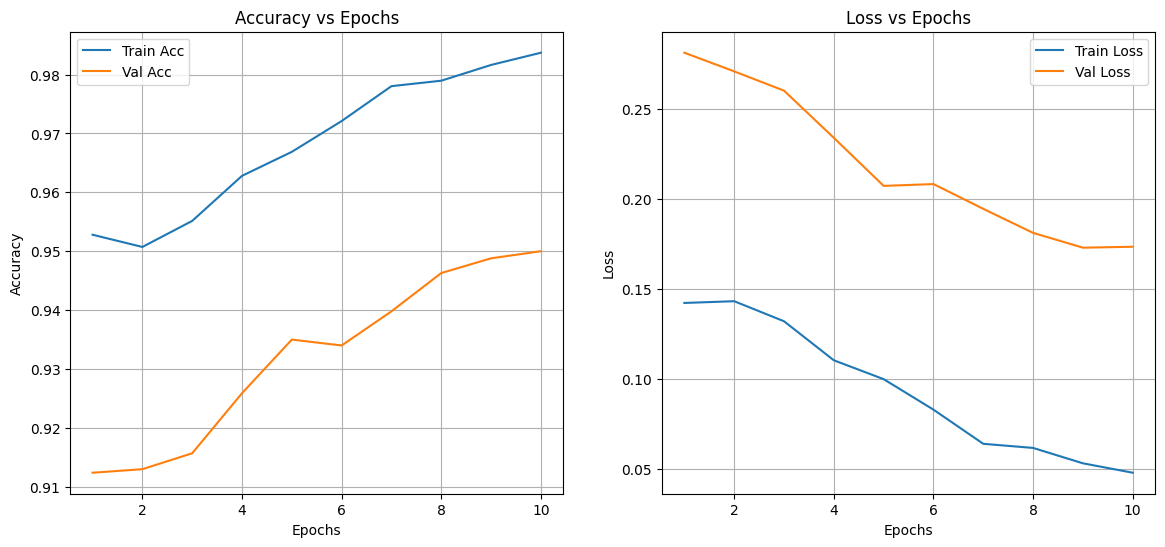

In [ ]:
epoch_hist = pd.read_csv(path_epoch_hist)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_hist["Epoch"], epoch_hist["Train Acc"], label="Train Acc")
plt.plot(epoch_hist["Epoch"], epoch_hist["Val Acc"], label="Val Acc")
plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Accuracy vs Epochs")
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(epoch_hist["Epoch"], epoch_hist["Train Loss"], label="Train Loss")
plt.plot(epoch_hist["Epoch"], epoch_hist["Val Loss"], label="Val Loss")
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss vs Epochs")
plt.grid(True)
plt.savefig(os.path.join(output_dir, "training_plots.png"))
plt.show()

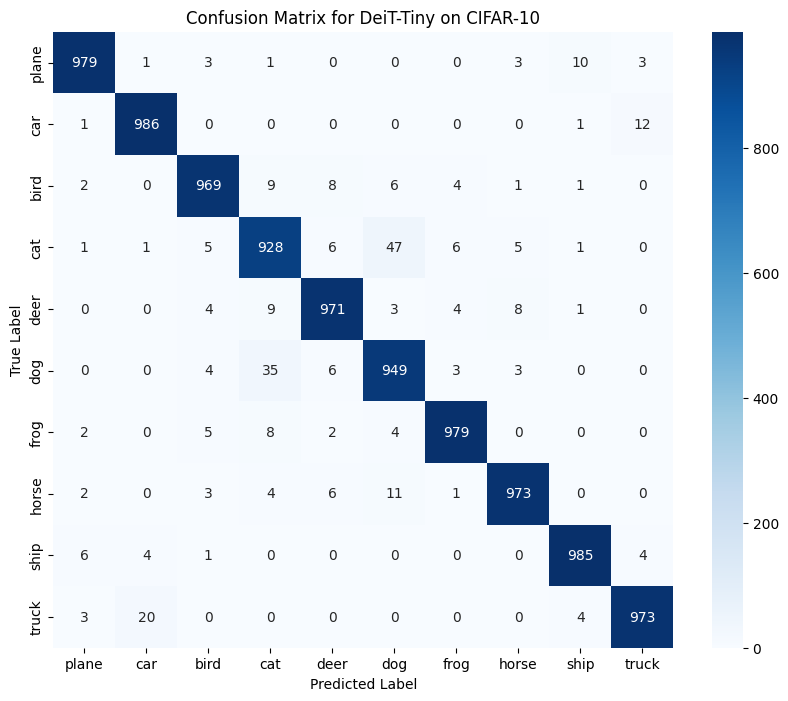

In [ ]:
# Plot Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for DeiT-Tiny on CIFAR-10')
plt.savefig(os.path.join(output_dir, "confusion_matrix.png"))
plt.show()

In [ ]:
summary_file = os.path.join(output_dir, "summary_metrics.csv")

if os.path.exists(summary_file):
    # Load the saved summary if it already exists
    summary_df = pd.read_csv(summary_file)
    print("\n" + "="*70)
    print("Loaded Summary")
    print("="*70)
    print(f"\033[1m{summary_df.T}")
else:
    # Only run this block after training is complete
    summary_df = pd.DataFrame([{
      "Model": "DeiT-Tiny",
      "Test Accuracy": test_acc,
      "Traing Accuracy": pd.read_csv(os.path.join(output_dir, "epoch_hist.csv"))["Train Acc"].iloc[-1],
      "Validation Accuracy": pd.read_csv(os.path.join(output_dir, "epoch_hist.csv"))["Val Acc"].iloc[-1],
      "Training Loss": pd.read_csv(os.path.join(output_dir, "epoch_hist.csv"))["Train Loss"].iloc[-1],
      "Precision": precision,
      "F1-Score": f1,
      "Recall": recall,
      "Training Time (s)": training_time if 'training_time' in locals() else pd.read_csv(os.path.join(output_dir, "summary_metrics.csv"))["Training Time (s)"].iloc[0],
      "Inference Time (ms)": infer_time * 1000,
      "Model Size (MB)": model_size,
    }])

    summary_df.to_csv(summary_file, index=False)
    print("\n" + "="*70)
    print("Saved Summary")
    print("="*70)
    print(f"\033[1m{summary_df.T}")


Loaded Summary
                               0
Model                  DeiT-Tiny
Test Accuracy             0.9692
Traing Accuracy           0.9837
Validation Accuracy         0.95
Training Loss           0.047763
Precision               0.969276
F1-Score                 0.96922
Recall                    0.9692
Training Time (s)    1870.267356
Inference Time (ms)     6.429911
Model Size (MB)        22.187181


In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(all_labels, all_preds, target_names=classes)

print("\n--- Per-Class Metrics ---")
print(report)
report_path = os.path.join(output_dir, "classification_report_per_class.csv")
with open(report_path, 'w') as f:
    f.write(report)
print(f"Classification report saved to '{report_path}'")


--- Per-Class Metrics ---
              precision    recall  f1-score   support

       plane       0.98      0.98      0.98      1000
         car       0.97      0.99      0.98      1000
        bird       0.97      0.97      0.97      1000
         cat       0.93      0.93      0.93      1000
        deer       0.97      0.97      0.97      1000
         dog       0.93      0.95      0.94      1000
        frog       0.98      0.98      0.98      1000
       horse       0.98      0.97      0.98      1000
        ship       0.98      0.98      0.98      1000
       truck       0.98      0.97      0.98      1000

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Classification report saved to '/content/drive/My Drive/Colab Notebooks/ViT_Tiny_Final/classification_report_per_class.csv'



GENERATING SAMPLE PREDICTIONS


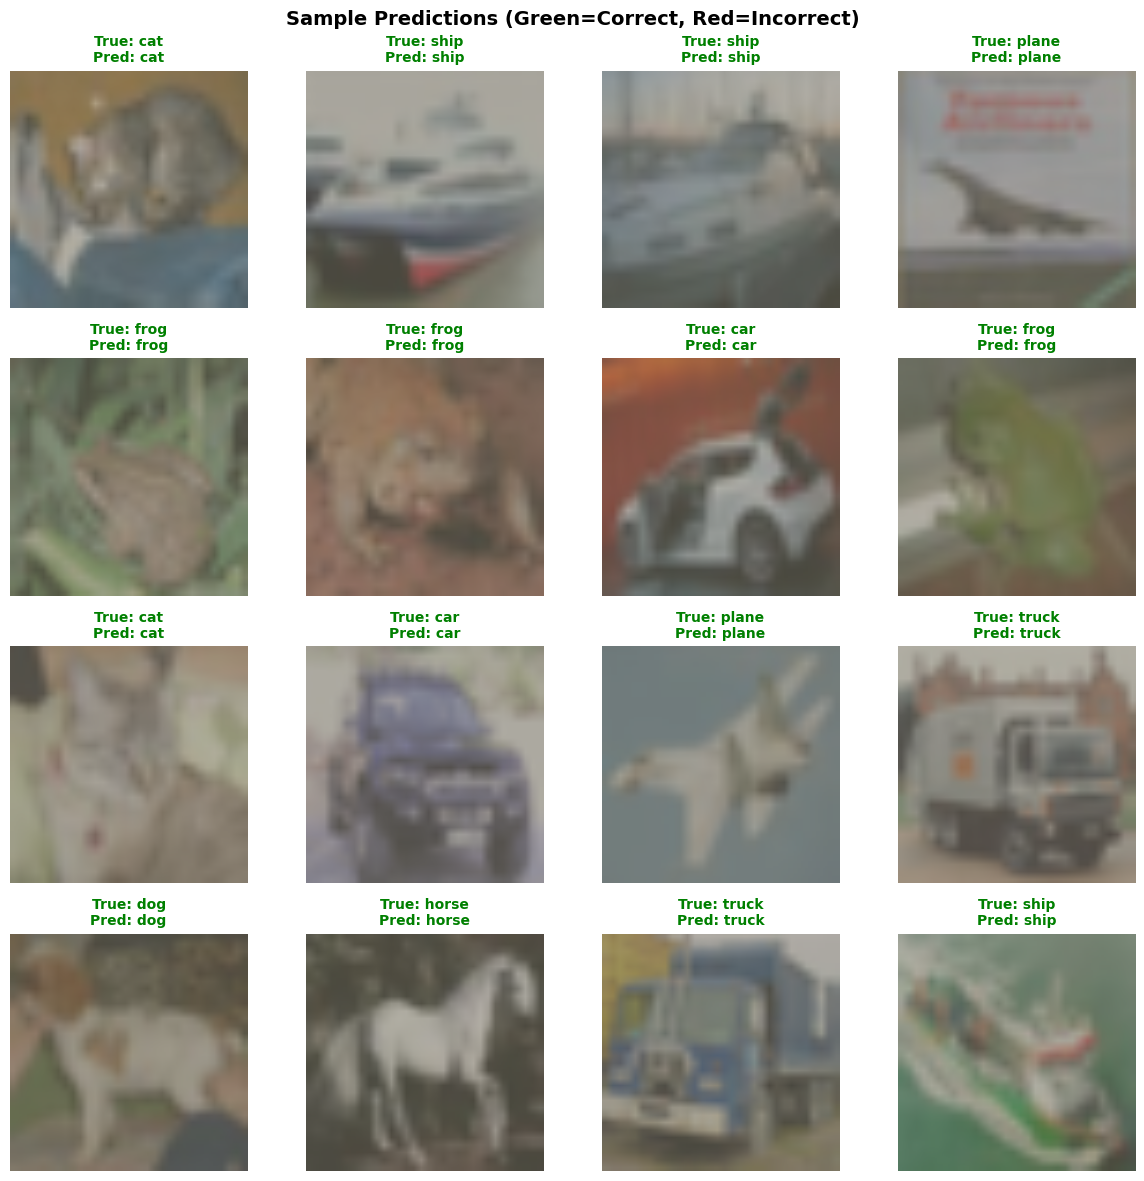

✓ Sample predictions saved as 'sample_predictions.png'


In [ ]:
print("\n" + "="*70)
print("GENERATING SAMPLE PREDICTIONS")
print("="*70)
# Get a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
# Make predictions
model.eval()
with torch.no_grad():
    outputs = model(images).logits
    _, predicted = torch.max(outputs, 1)
# Plot first 16 images with predictions
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for idx, ax in enumerate(axes.flat):
    if idx < len(images):
        # Denormalize image for display
        img = images[idx].cpu()
        img = img * torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
        img = img + torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
        img = torch.clamp(img, 0, 1)
        ax.imshow(img.permute(1, 2, 0))
        true_label = classes[labels[idx].item()]
        pred_label = classes[predicted[idx].item()]
        color = 'green' if labels[idx] == predicted[idx] else 'red'
        ax.set_title(f'True: {true_label}\nPred: {pred_label}',
                     color=color, fontsize=10, fontweight='bold')
        ax.axis('off')
plt.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)',
            fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig(os.path.join(output_dir,'sample_predictions.png'), dpi=150, bbox_inches='tight')
plt.show()
print("✓ Sample predictions saved as 'sample_predictions.png'")